In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

#-- bins for clustering (data and mocks)
from params import nbins, rp_min, rp_max, rp_bins, rp_mids, H0, bin_file_comoving #, bin_file

from mock_clust import sig_lin#, _model_wp, sig_tanh, _plot, _plot_mag_bins, _get_popt, _compile_chisq

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


In [2]:
def get_rp_use_tag(rp_use_range, return_tag=True, return_label=False):
    rp_use_min, rp_use_max = rp_use_range
    if (rp_use_min==None) & (rp_use_max==None):
        rp_use_tag   = "all-rp-bins"
        rp_use_label = "all-rp-bins"
        
        if rp_use_max != None:
            rp_use_tag   = f"rpmax{int(rp_use_max)}Mpch"
            rp_use_label = r"$r_{\rm p} < $" + f"${int(rp_use_max)}$" + r" $h^{-1} {\rm Mpc}$"
    elif (rp_use_min==None) and not (rp_use_max==None):
        assert(rp_use_max >= 20)
        rp_use_tag   = f"rpmax{str(round(rp_use_max,2)).replace('.','p')}Mpch"
        rp_use_label = r"$r_{\rm p} < $" + f"${rp_use_max:.2f}$" + r" $h^{-1} {\rm Mpc}$"
    elif not (rp_use_min==None) and (rp_use_max==None):
        rp_use_tag   = f"rpmin{str(round(rp_use_min,2)).replace('.','p')}Mpch"
        rp_use_label = r"$r_{\rm p} > $" + f"${rp_use_min:.2f}$" + r" $h^{-1} {\rm Mpc}$"
    else:
        assert((rp_use_min >= 0) & (rp_use_min < rp_use_max))
        rp_use_tag   = f"rp{str(round(rp_use_min,2)).replace('.','p')}-{int(rp_use_max)}Mpch"
        rp_use_label = f"${rp_use_min:.2f}$" + r"$ < r_{\rm p} < $" + f"${int(rp_use_max)}$" + r"$ h^{-1} {\rm Mpc}$"

    if (return_tag==True & return_label==False):
        return rp_use_tag
    elif (return_label==True & return_tag==False):
        return rp_use_label
    elif (return_tag==True & return_label==True):
        return rp_use_tag, rp_use_label
    else:
        return rp_use_tag
    

<a class="anchor" id="outline"></a>

* [Get scatter parameters](#scatter)
* [Mock magnitudes](#mock_mags)
* [Clustering](#clust)


# Set parameters


In [3]:
band   = "MW1"
zrange = (0.6,0.7)

sham_scatter_key = "sham_lin4"
los_scatter_key  = "los_lin4"
rp_use_range     = (0.1, None)
brightest_mag_bin_rp1Mpch = True

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.
print(f"h = {h}")

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

# abs_mag_ticks = np.arange(*abs_mag_range,0.5)

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

lf_name = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
lum_func  = np.load(lf_name).item()
lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()
#=========== END HOUSEKEEPING ===========#

t = Table(np.load(f"{BASEDIR}/mags_z0p40-0p70.npy"))

pz_mask = ((t["pz"]) >= zmin) & (t["pz"] < zmax)

abs_mag_bin_cens  = [np.mean(abs_mag_bins_clust[i:i+2]) for i in range(len(abs_mag_bins_clust)-1)]
abs_mag_bin_means = [np.round(np.mean(t[band][pz_mask & (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])]),3) for i in range(len(abs_mag_bins_clust)-1)]
abs_mag_bin_meds  = [np.round(np.median(t[band][pz_mask & (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])]),3) for i in range(len(abs_mag_bins_clust)-1)]

print(band)
print(zrange)

print(abs_mag_bin_cens)
print(abs_mag_bin_means)
print(abs_mag_bin_meds)


h = 0.6777


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


MW1
(0.6, 0.7)
[-27.025, -23.9, -23.6, -23.299999999999997]
[-24.363, -23.887, -23.592, -23.299]
[-24.288, -23.88, -23.588, -23.298]


<a class="anchor" id="scatter"></a>

# Get optimized scatter parameters

[BACK TO TOP](#outline)

### Compute and save $\chi^2(\omega_{\rm p})$ in magnitude bins for $\sigma_{\rm SHAM}\times\sigma_{\rm LOS}$ grid

In [4]:
# def chisq_array(this_band, zrange, sham_tag="vpeak", sim_tag=None, pimax=150, h=H0/100, zmag_lim=20.7,
#                 cross="GXG", d="south", rp_use_range=None, rp_cen=rp_mids, brightest_mag_bin_rp1Mpch=False):
#     this_zsnap_tag = get_zsnap_tag( np.array(z_snaps)[ np.round(z_snaps,1)==zrange[0] ][0] )
#     assert(sim_tag != None)
    
#     sigma_const_array = np.round(np.arange(0.,1.01,0.01),2)
#     sigma_los_array   = np.arange(0,151,5)
# #     sigma_const_array = np.arange(0.0,0.61,0.01)
# #     sigma_los_array   = np.arange(0,121,5)

#     abs_mag_bin_tags = get_abs_mag_bin_tags(zrange[0], this_band, nbins=4)

#     this_abs_mag_lim = get_abs_mag_lim(zrange[0], this_band)
#     if this_band=="Mr":
#         this_abs_mag_lim_tag = get_Mr_tag(this_abs_mag_lim)
#     elif this_band=="Mz":
#         this_abs_mag_lim_tag = get_Mz_tag(this_abs_mag_lim)
#     elif this_band=="MW1":
#         this_abs_mag_lim_tag = get_MW1_tag(this_abs_mag_lim)

#     print(f"\n{this_band} < {this_abs_mag_lim} ({d})\n{zrange[0]} < zphot < {zrange[1]} ({this_zsnap_tag})")
    
#     rp_use_min, rp_use_max = rp_use_range
#     rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
#     if brightest_mag_bin_rp1Mpch==True:
#         rp_use_tag += "_brightest-mag-bin-rp1Mpch"
#     print(rp_use_range, rp_use_tag)
        
#     save_path = f"{BASEDIR}/chisq/{rp_use_tag}"
#     Path( save_path ).mkdir(parents=True, exist_ok=True)
#     fname   = f"{d}_{sham_tag}_{this_abs_mag_lim_tag}_{this_zsnap_tag}.npy"
#     save_as = f"{save_path}/{fname}"

#     out = {}
        
#     for abs_mag_bin_tag in abs_mag_bin_tags:
#         print(abs_mag_bin_tag)

#         chisq_matrix = np.zeros([len(sigma_const_array),len(sigma_los_array)])
#         summary = []

#         #-- data
#         fpath_data    = f"{BASEDIR}/clustering/{zmag_tag}/{this_abs_mag_lim_tag}/{abs_mag_bin_tag}"
#         wp_fname_data = f"{fpath_data}/wp/{get_cat_tag(d, zrange)}_{cross}_pimax{int(pimax)}.txt"
        
#         if os.path.exists(wp_fname_data):
#             data = ascii.read(wp_fname_data)
#             rp_cen = h*data["rp_cen"]
#             wp     = h*data["wp"]
#             wp_err = h*data["wp_err"]

#             #-- if limiting rp > 1 Mpc/h for brightest mag bin and this mag bin is the brightest
#             if (brightest_mag_bin_rp1Mpch==True) and ("n30p0" in abs_mag_bin_tag):
#                 if (rp_use_max != None):
#                     rp_use_idx = np.where((rp_cen > 1.0) & (rp_cen < rp_use_max))[0]
#                 else:
#                     rp_use_idx = np.where(rp_cen > 1.0)[0]
#             else: #if brightest_mag_bin_rp1Mpch==False:
#                 if (rp_use_min != None) & (rp_use_max != None):
#                     rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
#                 elif (rp_use_min != None) & (rp_use_max==None):
#                     rp_use_idx = np.where(rp_cen > rp_use_min)[0]
#                 elif (rp_use_min==None) & (rp_use_max != None):
#                     rp_use_idx = np.where(rp_cen < rp_use_max)[0]
#                 else:
#                     rp_use_idx = np.arange(len(rp_cen))
#             print(rp_use_idx)
                        
#             rp_pi_counts_fname = f"{fpath_data}/rp_pi_counts/{get_cat_tag(d, zrange)}_{cross}.npy"
#             cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
#             cov_inv = np.linalg.inv(cov)

#             for u,sigma_const in enumerate(sigma_const_array):
#                 sc = str(round(sigma_const,2)).replace(".","p")

#                 #-- model
#                 fpath_model = f"{BASEDIR}/clustering/mocks/{sim_tag}/{sham_tag}/{zmag_tag}/{this_abs_mag_lim_tag}/{abs_mag_bin_tag}/sigma_sham_const{sc}"
#                 fname_model = f"{this_zsnap_tag}_{d}_{cross}_pimax{int(pimax)}.npy"
#                 if os.path.exists(f"{fpath_model}/{fname_model}"):
#                     model_all_sigma_los = np.load(f"{fpath_model}/{fname_model}", allow_pickle=True).item()
                    
#                     for v,sigma_los in enumerate(sigma_los_array):
#                         los_key = f"sigma_los_{int(sigma_los)}"
#                         if los_key in model_all_sigma_los.keys():
#                             model  = model_all_sigma_los[los_key]
#                             wp_mod = h*model["wp"]
#                             chisq_terms = [ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ]
#                             chisq = np.sum(chisq_terms)
#                             chisq_matrix[u][v] = chisq
#                             summary.append( [chisq, sigma_const, sigma_los] )

#         summary = Table(data=np.array(summary), names=("chisq","sigma_const","sigma_los"))
#         out[ abs_mag_bin_tag ] = ( summary, chisq_matrix )
    
#     # print(save_as)
#     np.save(save_as, out, allow_pickle=True)
        
#     return out


In [5]:
# %%time

# import itertools as it

# bands = ["Mz","MW1"]
# zmins = [0.4,0.5,0.6]
# rp_minima = [0.1]

# combos = list(it.product(bands, zmins, rp_minima))

# print(combos)

# for i in range(len(combos)):
#     this_band, this_zmin, rp_use_min = combos[i]
#     print(f"\n{i+1} / {len(combos)}")
#     test = chisq_array(this_band, (this_zmin,this_zmin+0.1), rp_use_range=(rp_use_min,None),
#                        sim_tag=sim_tag, brightest_mag_bin_rp1Mpch=True)
    
# print("DONE!")


<a class="anchor" id="mock_mags"></a>

# Create mock with magnitudes

[BACK TO TOP](#outline)

### Load simulation snapshot

In [6]:
%%time

###############################
## Load simulation snapshot  ##
###############################

a     = snaps["scale"][snaps["redshift"]==zsim][0]
scale = f"{a:.4f}"
scale = scale.replace(".","p")

quiet = False
sham_tag_min = 125

snap_fname = f"{SIMDIR}/{sim_tag}/CATALOGS/{sham_tag}min{int(sham_tag_min)}/a{scale}.npy"

if os.path.exists( snap_fname ):
    if not quiet:
        print(f"Loading simulation shapshot (zsim = {zsim}; {sham_tag} > {sham_tag_min})...")
    halocat = Table( np.load(snap_fname) )
    
halocat.sort( sham_tag )

halocat = halocat[::-1]


Loading simulation shapshot (zsim = 0.62813; vpeak > 125)...
CPU times: user 51.1 s, sys: 13.1 s, total: 1min 4s
Wall time: 1min 5s


In [7]:
%%time

###################################################################
##  Infer halo number densities from target luminosity function  ##
###################################################################

halocat = halocat[np.log10(halocat["parent_mvir"]) >= 11.5]
sham_var = halocat[sham_tag]

#-- get value of nh = nh( sham_var ) for each value of sham_var

#-- halo number counts in bins of (log_)sham_var
H,_ = np.histogram( np.log10(sham_var), bins=sham_var_bins )

#-- halo abundance versus (min log_)sham_var
cdf_log_sham_var = np.max(np.cumsum(H))-np.cumsum(H)

#-- interpolation function for nh of (log_)sham_var
nh_of_log_sham_var = interpolate.interp1d(sham_var_cens, np.array(cdf_log_sham_var)/vol_sim, fill_value="extrapolate")

#-- inferred halo number densities for sham_var values
nh_inferred = nh_of_log_sham_var( np.log10(sham_var) )

cname = "nh_inferred"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(nh_inferred, name=cname) )


###################################################################################
##  Assign luminosities *without* scatter based on inferred halo number density  ##
###################################################################################

#-- get corresponding value of abs_mag for inferred nh values: abs_mag = abs_mag( ngal_eff=nh )
abs_mag_bins = lum_func_full["abs_mag_bins"]
ngal_eff     = lum_func_full["ng_eff"]

#-- interpolation function for abs_mag of ngal_eff
abs_mag_of_ngal_eff = interpolate.interp1d(ngal_eff, abs_mag_bins[::-1], fill_value="extrapolate")

nh_inferred = halocat["nh_inferred"]
abs_mag_inferred = abs_mag_of_ngal_eff( nh_inferred )

#-- add inferred magnitudes (with MONOTONIC Vcirc correspondence) to halo catalog
cname = f"{band}_no_scatter"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred, name=cname) )

halocat[f"{band}_no_scatter"][halocat[f"{band}_no_scatter"]==-np.inf] = np.inf


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


CPU times: user 5.96 s, sys: 1.91 s, total: 7.87 s
Wall time: 7.88 s


In [8]:
def _compile_chisq(rp_use_range=None, d="south", band=None, zmin=None, sim_tag=None,
                   brightest_mag_bin_rp1Mpch=False):
    assert(sim_tag != None)
    rp_use_tag = get_rp_use_tag(rp_use_range, return_tag=True)
    if brightest_mag_bin_rp1Mpch==True:
        rp_use_tag += "_brightest-mag-bin-rp1Mpch"

    out = []

    mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=4)
    z_snaps,_,_ = get_zsnap_data(sim_tag)
    zsim      = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
    zsnap_tag = get_zsnap_tag(zsim)

    zsim = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
    zsnap_tag = get_zsnap_tag(zsim)

    abs_mag_lim = get_abs_mag_lim(zmin, band)
    if band=="Mr":
        abs_mag_lim_tag = get_Mr_tag(abs_mag_lim)
    elif band=="Mz":
        abs_mag_lim_tag = get_Mz_tag(abs_mag_lim)
    elif band=="MW1":
        abs_mag_lim_tag = get_MW1_tag(abs_mag_lim)

    #-- load linear fit mag bin chisq data
    print(rp_use_tag)
    fname = f"{BASEDIR}/chisq/{rp_use_tag}/{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}.npy"
    print(fname)
    chisq_linear = np.load(fname, allow_pickle=True).item()

    #-- parse mag bin keys
    mag_bin_tags = list(chisq_linear.keys())

    #-- define mag bin centers
    mag_bin_edges = [-float(j[1:].replace("p",".")) for j in np.array([i.split("-") for i in mag_bin_tags]).T[1]]
    mag_bin_cens  = [round(np.mean(mag_bins_clust[k:k+2]),3) for k in range(len(mag_bins_clust)-1)]

    for abs_mag_tag in abs_mag_bin_tags:
        bin_data = chisq_linear[abs_mag_tag][0]

        chisq = bin_data["chisq"]

        chisq_min1 = np.min(chisq)
        chisq_min1_idx = np.where(chisq==chisq_min1)[0][0]

        chisq_min2 = np.min(chisq[chisq!=chisq_min1])
        chisq_min2_idx = np.where(chisq==chisq_min2)[0][0]

        chisq_min3 = np.min(chisq[(chisq!=chisq_min1) & (chisq!=chisq_min2)])
        chisq_min3_idx = np.where(chisq==chisq_min3)[0][0]

        chisq_min4 = np.min(chisq[(chisq!=chisq_min1) & (chisq!=chisq_min2) & (chisq!=chisq_min3)])
        chisq_min4_idx = np.where(chisq==chisq_min4)[0][0]

        chisq_min5 = np.min(chisq[(chisq!=chisq_min1) & (chisq!=chisq_min2) & (chisq!=chisq_min3) & (chisq!=chisq_min4)])
        chisq_min5_idx = np.where(chisq==chisq_min5)[0][0]

        chunk = bin_data[[chisq_min1_idx,chisq_min2_idx,chisq_min3_idx,chisq_min4_idx,chisq_min5_idx]]

        chunk.add_column(Column(zsim*np.ones(len(chunk)), name="zsim"), index=1)
        chunk.add_column(Column(data=[band for j in range(len(chunk))], name="band"), index=2)
        chunk.add_column(Column(data=[abs_mag_tag for j in range(len(chunk))], name="mag_bin"), index=3)
    
        out.append(chunk)

    out = vstack(out)
    out["sigma_los"] = out["sigma_los"].astype(int)

    tmp = np.round(np.array(out["sigma_const"]),2)
    out.replace_column("sigma_const",tmp)

    tmp = np.round(np.array(out["chisq"]),1)
    out.replace_column("chisq",tmp)
    
    return out


In [9]:
print(rp_use_range)

kwargs = dict(band=band, zmin=zmin, sim_tag=sim_tag, rp_use_range=rp_use_range)

chisq_linear = _compile_chisq(**kwargs, brightest_mag_bin_rp1Mpch=True)

for mag_bin in np.unique(chisq_linear["mag_bin"])[::-1]:
    print(chisq_linear[chisq_linear["mag_bin"]==mag_bin])


(0.1, None)
rpmin0p1Mpch_brightest-mag-bin-rp1Mpch
/Users/aberti/Desktop/research/desi_lrg_sham/chisq/rpmin0p1Mpch_brightest-mag-bin-rp1Mpch/south_vpeak_MW1limn23p15_zsnap0p62813.npy
chisq   zsim  band     mag_bin     sigma_const sigma_los
----- ------- ---- --------------- ----------- ---------
  5.5 0.62813  MW1 MW1n30p0-n24p05        0.28       115
  5.6 0.62813  MW1 MW1n30p0-n24p05        0.36       110
  6.6 0.62813  MW1 MW1n30p0-n24p05        0.33       115
  6.9 0.62813  MW1 MW1n30p0-n24p05        0.64        90
  7.7 0.62813  MW1 MW1n30p0-n24p05        0.24       120
chisq   zsim  band     mag_bin      sigma_const sigma_los
----- ------- ---- ---------------- ----------- ---------
 25.5 0.62813  MW1 MW1n24p05-n23p75        0.29       105
 26.3 0.62813  MW1 MW1n24p05-n23p75        0.31       110
 27.7 0.62813  MW1 MW1n24p05-n23p75        0.32       110
 29.1 0.62813  MW1 MW1n24p05-n23p75        0.31       105
 29.2 0.62813  MW1 MW1n24p05-n23p75        0.33       105
chisq   zsim

/Users/aberti/Desktop/research/desi_lrg_sham/figures/params_MW1_zsim0p62813_rpmin0p1Mpch_brightest-mag-bin-rp1Mpch_chisq-min-all-mag-bins.png
[0.181 4.652]
[ -0. 110.]


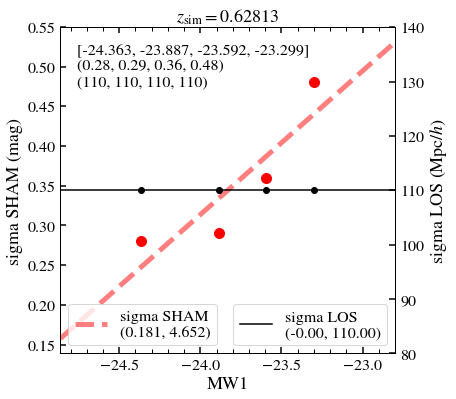

In [14]:
x = abs_mag_bin_means

y_vals = {"Mz": {0.4:( (0.31, 0.37, 0.40, 0.37), (105, 115, 115, 120) ),
                 
                 0.5:( (0.43, 0.31, 0.37, 0.44), (90, 100, 110, 125) ),
                 
                 0.6:( (0.34, 0.33, 0.40, 0.47), (105, 120, 115, 125) ),
                },
          
          "MW1":{0.4:( (0.25, 0.36, 0.44, 0.46), (105,105,105,110) ),
                 
                 0.5:( (0.31, 0.31, 0.31, 0.39), (105, 105, 105, 105) ),
                 
                 0.6:( (0.28, 0.29, 0.36, 0.48), (110, 110, 110, 110) ),
                },
         }
y_sham, y_los = y_vals[band][zmin]

popt_sham_lin4,_ = curve_fit( sig_lin, x, y_sham )
#popt_sham_lin4 = np.polyfit( x, y_sham, deg=1 )

m_sham, b_sham = popt_sham_lin4

popt_los_lin4,_ = curve_fit( sig_lin, x, y_los )
m_los, b_los = popt_los_lin4

mag_array = np.linspace(np.min(x)-0.5,np.max(x)+0.5,100)


fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.scatter(x, y_sham, marker="o", color="red", s=100)
ax.plot(mag_array, m_sham*mag_array+b_sham, color="red", ls="--", lw=5, alpha=0.5,
        label="sigma SHAM\n({:.3f}, {:.3f})".format(*popt_sham_lin4))

ax.set_xlim(np.min(mag_array), np.max(mag_array))
ax.set_xlabel(band)
ax.legend(loc=3, fontsize=16, frameon=True)
ax.set_title(r"$z_{\rm sim}=$"+f"${zsim}$")

ax.text(*get_corners(ax)["upper_left"], "{}\n{}\n{}".format(x,y_sham,y_los), ha="left", va="top")

ax_los = ax.twinx()

ax_los.scatter(x, y_los, color="black")
ax_los.plot(mag_array, m_los*mag_array+b_los, color="black",
            label="sigma LOS\n({:.2f}, {:.2f})".format(*popt_los_lin4))

ax.set_ylabel("sigma SHAM (mag)")
ax_los.set_ylabel("sigma LOS (Mpc/$h$)")
ax_los.set_ylim(80,140)
ax_los.legend(loc=4, fontsize=16, frameon=True)

rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
if brightest_mag_bin_rp1Mpch==True:
    rp_use_tag += "_brightest-mag-bin-rp1Mpch"

figname = f"{BASEDIR}/figures/params_{band}_zsim{str(zsim).replace('.','p')}_{rp_use_tag}_chisq-min-all-mag-bins.png"
print(figname)
# plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

print(np.round(popt_sham_lin4,3))
print(np.round(popt_los_lin4,2))

plt.show()


In [ ]:
# def _get_popt(band, zmin, mag_bin_cens=None, rp_use_range=(0.1,None), sim_tag="mdpl2", quiet=True,
#               plot=False, brightest_mag_bin_rp1Mpch=False):
#     assert(sim_tag != None)
#     # if not quiet:
#     #     print(f"zrange: ({zmin}, {zmin+0.1})")
#     #     print(f"band: {band}")
#     #     print(f"{rp_use_range}\n")
#     popt = {}
#     scatter_key = f"{band}_zmin{str(zmin).replace('.','p')}"

#     kwargs = dict(band=band, zmin=zmin, sim_tag=sim_tag, rp_use_range=rp_use_range,
#                   brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch)
#     out  = _compile_chisq(**kwargs)
#     mask = (out["band"]==band) & (np.round(out["zsim"],1)==zmin)
#     zsim = np.round(np.unique(out["zsim"][mask]),3)[0]

#     t = []
#     for mag in np.unique(out["mag"][mask]):
#         t.append(out[mask & (out["mag"]==mag)])
#     t = vstack(t)

#     if plot:
#         fig, axes = plt.subplots(1, 2, figsize=(12,5.5))

#         ax = axes[0]
#         ax.set_xlim(0.0,1.0)
#         ax.set_xlabel("sigma SHAM (mag)")
#         ax.set_ylim(0,155)
#         ax.set_ylabel("sigma LOS (Mpc/$h$)")
#         ax.grid()
#         colors = get_colors(len(np.unique(t["mag"])))

#     dd = []
#     colors = get_colors(4)
#     for color,mag in zip(colors,np.unique(t["mag"])):
#         mask = t["mag"]==mag
#         if plot:
#             s = 100
#             ax.scatter(np.mean(t["sigma_const"][mask]), np.mean(t["sigma_los"][mask]), color=color, label=f"{band} = {mag}", s=100)
#         sig_v   = np.mean(t["sigma_const"][mask])
#         sig_los = np.mean(t["sigma_los"][mask])
#         w = np.mean(1/t["chisq"][mask])
#         dd.append([mag, sig_v, sig_los, w])

#     dd = np.array(dd).T
#     if not mag_bin_cens==None:
#         assert(len(mag_bin_cens)==4)
#         dd[0] = mag_bin_cens

#     if plot:
#         ax.legend(frameon=True)

#     mag_array = np.linspace(np.min(dd[0])-1,np.max(dd[0])+1,100)

#     if plot:
#         ax = axes[1]
#         ax.set_xlim(np.min(dd[0])-1, np.max(dd[0])+1)
#         ax.set_xlabel(band)
#         ax.set_ylim(axes[0].get_xlim())
#         ax.set_ylabel(axes[0].get_xlabel())
#         ax.scatter(dd[0], dd[1], color="red")

# #        #-- tanh fit only possible if optimal scatter values for lowest three amgnitude bins *NOT* equal
# #     if ( (dd[1][1] != dd[1][2]) | (dd[1][1] != dd[1][3]) ) & (dd[1][0] < dd[1][1]):
# #         popt_sham_tanh,_ = curve_fit( sig_tanh, dd[0], dd[1], bounds=((0,0,-25),(1,2,-20)) )
# #         if plot:
# #             ax.plot(mag_array, sig_tanh(mag_array, *popt_sham_tanh), color="red", label="sigma SHAM tanh (4 bins)")
# #         popt["sham_tanh"] = popt_sham_tanh

#     popt_sham_lin3,_  = curve_fit( sig_lin, dd[0][1:], dd[1][1:] )
#     popt["sham_lin3"] = popt_sham_lin3

#     popt_sham_lin4,_  = curve_fit( sig_lin, dd[0], dd[1] )
#     popt["sham_lin4"] = popt_sham_lin4

#     if plot:
#         ax.plot(mag_array, sig_lin(mag_array, *popt_sham_lin3), color="b", ls="-", label="sigma SHAM linear (3 bins)")
#         ax.plot(mag_array, sig_lin(mag_array, *popt_sham_lin4), color="k", ls="--", label="sigma SHAM linear (4 bins)")
#         ax.legend(loc=2)
#         ax = axes[1].twinx()
#         ax.set_ylim(axes[0].get_ylim())
#         ax.set_ylabel(axes[0].get_ylabel())
#         ax.scatter(dd[0], dd[2], marker="x", color="black")

#     #-- linear fit sigma_LOS(mag) to 3 dimmest mag bins
#     popt_los_lin3,_  = curve_fit( sig_lin, dd[0][1:], dd[2][1:] )
#     popt["los_lin3"] = popt_los_lin3
#     #-- linear fit sigma_LOS(mag) to all 4 mag bins
#     popt_los_lin4,_  = curve_fit( sig_lin, dd[0], dd[2] )
#     popt["los_lin4"] = popt_los_lin4
#     #-- single sigma_LOS value for each mag bin (excluding brightest)
#     popt["los_binned3"] = np.mean(dd[2][1:])
#     #-- single sigma_LOS value for each mag bin (excluding brightest)
#     popt["los_binned4"] = np.mean(dd[2])
    
#     if plot:
#         ax.plot(mag_array, sig_lin(mag_array, *popt_los_lin3), color="gray", lw=8, alpha=0.4, label="sigma LOS linear (3 bins)")
#         ax.plot(mag_array, sig_lin(mag_array, *popt_los_lin4), color="black", lw=1.5, ls=":", label="sigma LOS linear (4 bins)")

#         ax.legend(loc=4, markerfirst=False)
#         ax.text(get_corners(ax)["upper_left"][0], 90, r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$\n" + r"${\rm model}$", ha="left", va="top", fontsize=20)
#         plt.tight_layout()

#     return popt


In [15]:
%%time

#################################################
##  Set functional type for mag_vpeak scatter  ##
#################################################

mock_scatter_tag = f"{sham_scatter_key.replace('_','-')}"

rp_use_tag = get_rp_use_tag(rp_use_range, return_tag=True)
if brightest_mag_bin_rp1Mpch==True:
    rp_use_tag += "_brightest-mag-bin-rp1Mpch"

nsig_clip = 2.5


#################################################
##  Compute sigma array for mag-vpeak scatter  ##
#################################################

#popt = _get_popt(band, zmin, mag_bin_cens=abs_mag_bin_means, rp_use_range=rp_use_range, sim_tag=sim_tag, quiet=False)
popt = {"sham_lin4":popt_sham_lin4, "los_lin4":popt_los_lin4}
print(popt)

sigma_abs_mag_inferred = sig_lin(halocat[f"{band}_no_scatter"], *popt[ sham_scatter_key ])
# if "tanh" in sham_scatter_key:
#     sigma_abs_mag_inferred = sig_tanh(halocat[f"{band}_no_scatter"], *popt[ sham_scatter_key ])
# elif "lin" in sham_scatter_key:
#     sigma_abs_mag_inferred = sig_lin(halocat[f"{band}_no_scatter"], *popt[ sham_scatter_key ])

#-- replace negative sigma values with zero if needed
sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred < 0)[0]] = 0

#-- add scatter to inferred magnitudes
abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"], sigma_abs_mag_inferred)


###########################################
##  Add scattered magnitudes to catalog  ##
###########################################

#-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog
cname = f"{band}_scattered"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred_scattered, name=cname) )

halocat.sort( f"{band}_scattered" )

abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
abs_mag_inferred_sorted.sort()

if band in halocat.colnames:
    halocat.remove_column( band )
halocat.add_column( Column(abs_mag_inferred_sorted, name=band) )


##########################################
##  Flag (sub)halos with mock galaxies  ##
##########################################

#-- remove extra columns
cols = (f"{band}_scattered", "nh_inferred", "galaxy")
for c in cols:
    if c in halocat.colnames:
        halocat.remove_column(c)

#-- sort catalog by model magnitude       
halocat.sort( band )

#-- add column for galaxy flag
c = "galaxy"
if c in halocat.colnames:
    halocat.remove_column(c)
halocat.add_column(Column(np.zeros(len(halocat),dtype=bool), name=c))

#-- number of (sub)halos to select based on number density from data
Nhalo_select = int(np.max(lum_func["ng_eff"])*vol_sim)

#-- flag halos with galaxies
halocat["galaxy"][:Nhalo_select] = True

#################################
##  Save mock with magnitudes  ##
#################################

fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{mock_scatter_tag}_{rp_use_tag}.npy"
print(fname)

np.save(fname, halocat)

this_zsim      = zsim
this_zsnap_tag = zsnap_tag

this_abs_mag_lim_tag = abs_mag_lim_tag
this_zmin, this_zmax = zrange

mock_scatter_tag = f"{sham_scatter_key.replace('_','-')}"


{'sham_lin4': array([0.18075186, 4.65172828]), 'los_lin4': array([-2.73622585e-07,  1.09999993e+02])}
/Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/zsnap0p62813_zmaglim20p7_MW1limn23p15_sham-lin4_rpmin0p1Mpch_brightest-mag-bin-rp1Mpch.npy
CPU times: user 48.2 s, sys: 14 s, total: 1min 2s
Wall time: 1min 6s


In [16]:
def _model_wp(band, zmin,
              cat                = None,
              d                  = "south",
              DS                 = 1,
              n_iter             = 1,
              nthreads           = 2,
              BASEDIR            = None,
              return_model_error = False,
              sham_tag           = "vpeak",
              sim_tag            = None,
              cat_tag            = None,
              zmag_tag           = "zmaglim20p7",
              boxsize            = None,
              abs_mag_lim_tag    = None,
              abs_mag_bin_tags   = None,
              pimax              = 150.,
              rp_use_range       = None,
              brightest_mag_bin_rp1Mpch = True,
              bin_file           = None,
              sham_scatter_key   = None,
              los_scatter_key    = None,
              popt               = None,
              quiet              = True,
             ):
    assert(sim_tag != None)
    
    z_snaps,_,_ = get_zsnap_data(sim_tag)
    zsim      = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
    zsnap_tag = get_zsnap_tag(zsim)

    mock_scatter_tag = f"{sham_scatter_key.replace('_','-')}"
    rp_use_tag       = get_rp_use_tag(rp_use_range)
    if brightest_mag_bin_rp1Mpch==True:
        rp_use_tag += "_brightest-mag-bin-rp1Mpch"
    #popt = _get_popt(band, zmin, rp_use_range=rp_use_range, sim_tag=sim_tag)

    if cat==None:
        f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{mock_scatter_tag}_{rp_use_tag}"

        galcat_fname = f"{f}_galcat_LRG-flagged.npy"
        if not os.path.exists(galcat_fname):
            galcat_fname = f"{f}.npy"
        if not quiet:
            print(f"Loading {galcat_fname}...\n")

        cat = Table(np.load(galcat_fname))
    cat = cat[cat["galaxy"]==True]

    #-- compute sigma_los for specified parameterization
    if los_scatter_key==None:
        sigma_los = np.zeros(len(cat))
    else:
        sigma_los = sig_lin(cat[band].data, *popt[los_scatter_key])
    sigma_los[np.where(sigma_los < 0)[0]] = 0

    if abs_mag_bin_tags != None:
        model_mags = cat[band].data
        to_return  = {}
        for i,tag in enumerate(abs_mag_bin_tags):
            mag_min = -np.float(tag.split("-")[0].split("n")[-1].replace("p","."))
            mag_max = -np.float(tag.split("-")[-1].split("n")[-1].replace("p","."))
            mag_mask = (model_mags > mag_min) & (model_mags <= mag_max)
            out = []
            for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
                xx = cat[u]
                yy = cat[v]
                zz = cat[w]
                z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
                z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
                z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)
                
                args = (boxsize, pimax, nthreads, bin_file, xx[mag_mask][::DS], yy[mag_mask][::DS])
                out.append([wp_corrfunc(*args, z_s[mag_mask][::DS], output_rpavg=False)["wp"] for z_s in z_scatter])

            out = np.concatenate(out).T

            wp_mean = np.mean(out, axis=1)
            std     = np.std(out, axis=1)
            model   = Table([rp_mids,wp_mean,std], names=("rp_cen","wp","wp_err"))
            
            if return_model_error:
                to_return[tag] = model
            else:
                to_return[tag] = wp_mean
        return to_return
    else:
        out = []
        for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
            xx = cat[u][::DS]
            yy = cat[v][::DS]
            zz = cat[w][::DS]
            z_scatter = np.array([np.random.normal(zz, sigma_los[::DS], len(zz)) for idx in range(n_iter)])
            z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
            z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

        out = np.concatenate(out).T

        wp_mean = np.mean(out, axis=1)
        std     = np.std(out, axis=1)
        model   = Table([rp_mids,wp_mean,std], names=("rp_cen","wp","wp_err"))

        if return_model_error:
            return model
        else:
            return wp_mean
        

        
def _plot(band, zmin,
          cat                = None,
          sham_scatter_key   = None,
          los_scatter_key    = None,
          DS                 = 1,
          n_iter             = 1,
          boxsize            = None,
          BASEDIR            = None,
          return_model_error = False,
          h                  = H0/100,
          d                  = "south",
          pimax              = 150.,
          zmag_lim           = 20.7,
          cross              = "GXG",
          quiet              = True,
          save               = True,
          rp_use_range       = None,
          brightest_mag_bin_rp1Mpch = True,
          popt               = None,
          bin_file           = None,
          sim_tag            = None,
         ):
    
    assert(sim_tag != None)
    zmag_tag = get_zmag_tag(zmag_lim)
    MW1lim   = get_abs_mag_lim(zmin,"MW1")
    Mrlim    = get_abs_mag_lim(zmin,"Mr")
    Mzlim    = get_abs_mag_lim(zmin,"Mz")
    if band=="MW1":
        abs_mag_lim_tag = get_MW1_tag(MW1lim)
    elif band=="Mr":
        abs_mag_lim_tag = get_Mr_tag(Mrlim)
    elif band=="Mz":
        abs_mag_lim_tag = get_Mz_tag(Mzlim)
    else:
        raise Exception()

    zmax = zmin + 0.1
    # print(f"{band}\t({zmin:.1f},{zmax:.1f})\n")
    
    cat_tag = get_cat_tag(d,(zmin,zmin+0.1))
    if band=="MW1":
        abs_mag_lim_tag = get_MW1_tag( get_abs_mag_lim(zmin,"MW1") )
    elif band=="Mr":
        abs_mag_lim_tag = get_Mr_tag( get_abs_mag_lim(zmin,"Mr") )
    elif band=="Mz":
        abs_mag_lim_tag = get_Mz_tag( get_abs_mag_lim(zmin,"Mz") )
    else:
        raise Exception()

    #-- data
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"
    fpath = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
    if not os.path.exists(f"{fpath}/{wp_fname}"):
        fpath = f"{BASEDIR}/clustering/{zmag_tag}/v0.2/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
        
    data = ascii.read(f"{fpath}/{wp_fname}")
    rp_cen = h*data["rp_cen"]
    wp     = h*data["wp"]
    wp_err = h*np.sqrt(data["wp_err"])

    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
    cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
    cov_inv = np.linalg.inv(cov)
    
    kwargs_model_wp = dict(DS=DS, n_iter=n_iter, boxsize=boxsize, BASEDIR=BASEDIR, cat_tag=cat_tag, cat=cat,
                           return_model_error=return_model_error, abs_mag_lim_tag=abs_mag_lim_tag,
                           sham_scatter_key=sham_scatter_key, los_scatter_key=los_scatter_key, sim_tag=sim_tag,
                           rp_use_range=rp_use_range, quiet=quiet, bin_file=bin_file, popt=popt)
    models = {}
    sham_scatter_tag = sham_scatter_key.replace("_","-")
    if los_scatter_key != None:
        fig_scatter_tag  = f"{sham_scatter_tag}_{los_scatter_key.replace('_','-')}"
    else:
        fig_scatter_tag  = f"{sham_scatter_tag}_los-None"

    args   = (band, zmin)
    wp_mod = _model_wp(*args, **kwargs_model_wp)
    models[sham_scatter_tag] = wp_mod
        
    rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
    if brightest_mag_bin_rp1Mpch==True:
        rp_use_tag += "_brightest-mag-bin-rp1Mpch"
        
    rp_use_min, rp_use_max = rp_use_range
    if (rp_use_min != None) & (rp_use_max != None):
        rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
    elif (rp_use_min != None) & (rp_use_max==None):
        rp_use_idx = np.where(rp_cen > rp_use_min)[0]
    elif (rp_use_min==None) & (rp_use_max != None):
        rp_use_idx = np.where(rp_cen < rp_use_max)[0]
    else:
        rp_use_idx = np.arange(len(rp_cen))

    N_rp  = len(rp_use_idx)
    N_dof = 4 #if "tanh" in sham_scatter_tag else 4

    #-- make the figure
    fig, ax = plt.subplots(1, 1, figsize=(8,7))

    ax.set_xlim(0.02, 50)
    ax.set_ylim(20, 140)
    ax.tick_params(axis="both", which="major", labelsize=26)
    ax.set_xlabel(fig_labels["rp"], fontsize=30)
    ax.set_ylabel(fig_labels["rpwp"], fontsize=30)

    if zmin==0.4:
        mag_label = r"$\ (^{0.43}M_{W1} < $" if (band=="MW1") else r"$\ (^{0.43}M_z < $"
    elif zmin==0.5:
        mag_label = r"$\ (^{0.52}M_{W1} < $" if (band=="MW1") else r"$\ (^{0.52}M_z < $"
    elif zmin==0.6:
        mag_label = r"$\ (^{0.63}M_{W1} < $" if (band=="MW1") else r"$\ (^{0.63}M_z < $"
    abs_mag_lim = get_abs_mag_lim(zmin, band)
    data_label = r"${\rm data}$" + mag_label + f"${abs_mag_lim})$"

    #-- plot data points
    ax.errorbar(rp_cen, rp_cen*wp, yerr=rp_cen*wp_err, label=data_label, marker="o", ms=5, color="k", linestyle="")

    #-- plot models
    colors = get_colors(3)
    lines  = ("-", "dashdot", "--", ":")
    
    for idx,k in enumerate(models.keys()):
        wp_mod = h*models[k]
        chisq  = np.sum([ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
        #chisq_dof = chisq/(N_rp - N_dof)
        #chisq_label = r"$\chi^2_{\nu}=\ $" + f"${int(chisq_dof)}$"
        chisq_label = r"$\chi^2=\ $" + f"${int(chisq)}$"
        model_label = r"${\rm model}$" + f" $(${rp_use_label}$)$" #;${chisq_label}$)$"
        ax.plot(rp_cen, rp_cen*wp_mod, color=colors[idx], label=model_label, lw=2, ls=lines[idx])

    zphot_label = f"${zmin}$" + r"$ < z_{\rm phot} < $" + f"${zmax}$"
    ax.text(get_corners(ax, logx=True, margin=0.05)["upper_left"][0], 105, zphot_label, ha="left", va="top", fontsize=26)

    ax.legend(fontsize=26, loc=2, handletextpad=0.25, numpoints=2, handlelength=1.5)
    ax.semilogx()
    if rp_use_min != None:
        ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    if rp_use_max != None:
        ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

    plt.tight_layout()

    if brightest_mag_bin_rp1Mpch==True:
        fpath = f"{BASEDIR}/figures/wp_model-vs-data/rpmin0p1Mpch_brightest-mag-bin-rp1Mpch/{band}/{cat_tag[:-6]}"
    else:
        fpath = f"{BASEDIR}/figures/wp_model-vs-data/{band}/{cat_tag[:-6]}"
    fname = f"{abs_mag_lim_tag}_{fig_scatter_tag}_{rp_use_tag}.png"
    if not save:
        print(f"{fpath}/{fname}")
    elif save:
        print(f"\n{now()} Saving {fpath}/{fname}...")
        plt.savefig(f"{fpath}/{fname}", bbox_inches="tight", pad_inches=0.1, dpi=200)
    return

    

def _plot_mag_bins(band, zmin,
                   cat                = None,
                   sham_scatter_key   = None,
                   los_scatter_key    = None,
                   DS                 = 1,
                   n_iter             = 1,
                   boxsize            = None,
                   BASEDIR            = None,
                   return_model_error = False,
                   n_mag_bins_clust   = 4,
                   h                  = H0/100,
                   d                  = "south",
                   pimax              = 150.,
                   zmag_lim           = 20.7,
                   cross              = "GXG",
                   quiet              = False,
                   save               = True,
                   rp_use_range       = None,
                   brightest_mag_bin_rp1Mpch = True,
                   popt               = None,
                   bin_file           = None,
                   sim_tag            = None,
                  ):
    assert(sim_tag != None)
    zmag_tag = get_zmag_tag(zmag_lim)
    MW1lim   = get_abs_mag_lim(zmin,"MW1")
    Mrlim    = get_abs_mag_lim(zmin,"Mr")
    Mzlim    = get_abs_mag_lim(zmin,"Mz")
    if band=="MW1":
        abs_mag_lim_tag = get_MW1_tag(MW1lim)
    elif band=="Mr":
        abs_mag_lim_tag = get_Mr_tag(Mrlim)
    elif band=="Mz":
        abs_mag_lim_tag = get_Mz_tag(Mzlim)
    else:
        raise Exception()

    zmax = zmin + 0.1
    
    cat_tag = get_cat_tag(d,(zmin,zmin+0.1))
    if band=="MW1":
        abs_mag_lim_tag = get_MW1_tag( get_abs_mag_lim(zmin,"MW1") )
    elif band=="Mr":
        abs_mag_lim_tag = get_Mr_tag( get_abs_mag_lim(zmin,"Mr") )
    elif band=="Mz":
        abs_mag_lim_tag = get_Mz_tag( get_abs_mag_lim(zmin,"Mz") )
    else:
        raise Exception()
        
    abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
    abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

    sham_scatter_tag = sham_scatter_key.replace("_","-")
    sham_scatter_tag = sham_scatter_key.replace("_","-")
    if los_scatter_key != None:
        fig_scatter_tag  = f"{sham_scatter_tag}_{los_scatter_key.replace('_','-')}"
    else:
        fig_scatter_tag  = f"{sham_scatter_tag}_los-None"
    args = (band, zmin)
    kwargs_model_wp = dict(DS=DS, n_iter=n_iter, boxsize=boxsize, BASEDIR=BASEDIR, cat_tag=cat_tag, cat=cat,
                           return_model_error=return_model_error, abs_mag_lim_tag=abs_mag_lim_tag, bin_file=bin_file,
                           abs_mag_bin_tags=abs_mag_bin_tags, rp_use_range=rp_use_range, quiet=quiet, sim_tag=sim_tag,
                           sham_scatter_key=sham_scatter_key, los_scatter_key=los_scatter_key, popt=popt)
    models = _model_wp(*args, **kwargs_model_wp)
    
    rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
    if brightest_mag_bin_rp1Mpch==True:
        rp_use_tag += "_brightest-mag-bin-rp1Mpch"
    
    rp_cen = h*rp_mids
    rp_use_min, rp_use_max = rp_use_range

    #-- make the figure
    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    ax.set_xlim(0.02, 50)
    ax.set_ylim(1, 6e3)
    ax.tick_params(axis="both", which="major", labelsize=26)
    ax.set_xlabel(fig_labels["rp"], fontsize=30)
    ax.set_ylabel(fig_labels["wp"], fontsize=30)
    
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"
    colors = get_colors(len(abs_mag_bin_tags))
    lines  = ("-", "dashdot", "--", ":", "-")

    for idx,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
        fpath = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
        
        data = ascii.read(f"{fpath}/{wp_fname}")
        rp_cen = h*data["rp_cen"]
        wp     = h*data["wp"]
        wp_err = h*np.sqrt(data["wp_err"])

        rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
        cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
        cov_inv = np.linalg.inv(cov)

        #-- plot models    
        wp_mod = h*models[abs_mag_bin_tag]
        
        if (brightest_mag_bin_rp1Mpch==True) and ("n30p0" in abs_mag_bin_tag):
            if (rp_use_max != None):
                rp_use_idx = np.where((rp_cen > 1.0) & (rp_cen < rp_use_max))[0]
            else:
                rp_use_idx = np.where(rp_cen > 1.0)[0]
        else:
            if (rp_use_min != None) & (rp_use_max != None):
                rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
            elif (rp_use_min != None) & (rp_use_max==None):
                rp_use_idx = np.where(rp_cen > rp_use_min)[0]
            elif (rp_use_min==None) & (rp_use_max != None):
                rp_use_idx = np.where(rp_cen < rp_use_max)[0]
            else:
                rp_use_idx = np.arange(len(rp_cen))

        N_rp  = len(rp_use_idx)
        N_dof = 4 #if "tanh" in sham_scatter_tag else 4
        
        chisq  = np.sum([ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
        #chisq_dof = chisq/(N_rp - N_dof)
        #chisq_label = r"$\chi^2_{\nu}=\ $" + f"${int(chisq_dof)}$"
        chisq_label = r"$\chi^2=\ $" + f"${int(chisq)}$"
        model_label = r"${\rm model}$" + f" $(${rp_use_label}$)$"#;${chisq_label}$)$"
        print(f"{abs_mag_bin_tag}\t{chisq:.1f}")
        ax.plot(rp_cen, wp_mod, color=colors[idx], label="", lw=2, ls=lines[idx])

        #-- plot data points
        mag_label = get_abs_mag_bin_label(abs_mag_bin_tag)
        ax.errorbar(rp_cen, wp, yerr=wp_err, label=mag_label, marker="o", ms=5, color=colors[idx], linestyle="")

    zphot_label = f"${zmin}$" + r"$ < z_{\rm phot} < $" + f"${zmax}$" + f"\n{rp_use_label}"
    ax.text(*get_corners(ax, log=True, margin=0.05)["upper_right"], zphot_label, ha="right", va="top", fontsize=26)

    ax.legend(fontsize=26, loc=3, handletextpad=0.25, labelspacing=0.3, numpoints=2, handlelength=1.5)
    ax.loglog()

    if rp_use_min != None:
        ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    if rp_use_max != None:
        ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

    plt.tight_layout()

    if brightest_mag_bin_rp1Mpch==True:
        fpath = f"{BASEDIR}/figures/wp_model-vs-data/rpmin0p1Mpch_brightest-mag-bin-rp1Mpch/{band}/{cat_tag[:-6]}"
    else:
        fpath = f"{BASEDIR}/figures/wp_model-vs-data/{band}/{cat_tag[:-6]}"
    fname = f"{abs_mag_lim_tag}_{fig_scatter_tag}_{rp_use_tag}_mag-bins.png"
    if not save:
        print(f"{fpath}/{fname}")
    elif save:
        print(f"\n{now()} Saving {fpath}/{fname}...")
        plt.savefig(f"{fpath}/{fname}", bbox_inches="tight", pad_inches=0.1, dpi=200)
    return


rp_use_range = (0.1, None)
rp_use_tag   = rpmin0p1Mpch_brightest-mag-bin-rp1Mpch
sham_scatter_key = sham_lin4
los_scatter_key  = los_lin4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/table.py:2653: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


/Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_model-vs-data/rpmin0p1Mpch_brightest-mag-bin-rp1Mpch/MW1/z0p60-0p70/MW1limn23p15_sham-lin4_los-lin4_rpmin0p1Mpch_brightest-mag-bin-rp1Mpch.png
MW1n30p0-n24p05	17.4
MW1n24p05-n23p75	88.4
MW1n23p75-n23p45	61.7
MW1n23p45-n23p15	66.4
/Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_model-vs-data/rpmin0p1Mpch_brightest-mag-bin-rp1Mpch/MW1/z0p60-0p70/MW1limn23p15_sham-lin4_los-lin4_rpmin0p1Mpch_brightest-mag-bin-rp1Mpch_mag-bins.png
CPU times: user 27.4 s, sys: 3.27 s, total: 30.7 s
Wall time: 28.2 s


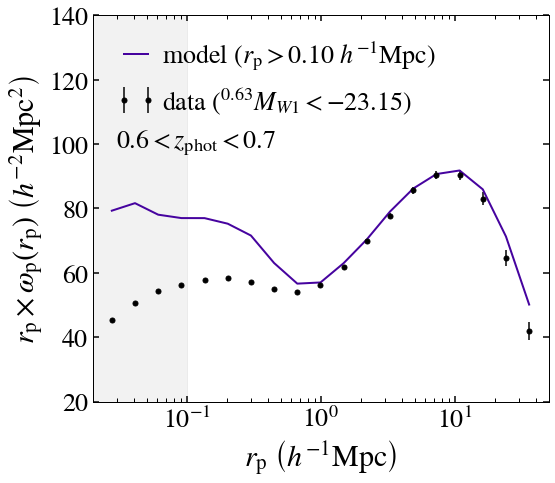

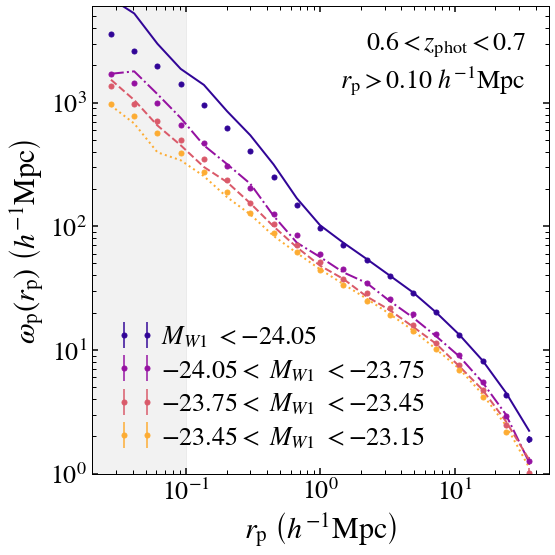

In [17]:
%%time

print(f"rp_use_range = {rp_use_range}")
print(f"rp_use_tag   = {rp_use_tag}")
print(f"sham_scatter_key = {sham_scatter_key}")
print(f"los_scatter_key  = {los_scatter_key}")

kwargs = dict(DS=1, n_iter=1, boxsize=get_boxsize(sim_tag), BASEDIR=BASEDIR, cat=halocat, sim_tag=sim_tag,
              brightest_mag_bin_rp1Mpch = True,
              rp_use_range     = rp_use_range,
              sham_scatter_key = sham_scatter_key,
              los_scatter_key  = los_scatter_key,
              popt             = popt,
              quiet            = False,
              save             = False,
              bin_file         = bin_file_comoving,
             )

_plot(band, zmin, **kwargs)

_plot_mag_bins(band, zmin, **kwargs)


In [ ]:
# PRIORITIZE LOWER SHAM SCATTER IN HIGHEST MAG BIN (GREATER LOS SCATTER)

# Mz
# 0.4 < z < 0.5
# Mzn30p0-n22p35	27.0 (rp > 1.0)
# Mzn22p35-n22p1	69.9
# Mzn22p1-n21p85	59.4
# Mzn21p85-n21p6	63.9

# *** 0.5 < z < 0.6
# Mzn30p0-n22p35	17.1 (rp > 1.0)
# Mzn22p35-n22p1	41.4
# Mzn22p1-n21p85	25.7
# Mzn21p85-n21p6	47.2

# 0.6 < z < 0.7
# Mzn30p0-n22p60	1368.5 (rp > 0.1)
# Mzn30p0-n22p60	20.0 (rp > 1.0)
# Mzn22p6-n22p35	41.1
# Mzn22p35-n22p1	51.4
# Mzn22p1-n21p85	62.1

# *** MW1
# 0.4 < z < 0.5
# MW1n30p0-n23p15		36.0 (rp > 1.0)
# MW1n23p15-n22p85	46.5
# MW1n22p85-n22p55	69.4
# MW1n22p55-n22p25	147.7

# 0.5 < z < 0.6
# MW1n30p0-n23p75	13.0 (rp > 1.0)
# MW1n23p75-n23p45	55.2
# MW1n23p45-n23p15	29.7
# MW1n23p15-n22p85	83.5

# 0.6 < z < 0.7
# MW1n30p0-n24p05	17.4 (rp > 1.0)
# MW1n24p05-n23p75	88.4
# MW1n23p75-n23p45	61.7
# MW1n23p45-n23p15	66.4

<a class="anchor" id="clust"></a>

# Clustering

[BACK TO TOP](#outline)


In [ ]:
# def _tolp(band, zmin,
#           cat                = None,
#           sham_scatter_key   = None,
#           los_scatter_key    = None,
#           DS                 = 1,
#           n_iter             = 1,
#           boxsize            = None,
#           BASEDIR            = None,
#           return_model_error = False,
#           h                  = H0/100,
#           d                  = "south",
#           pimax              = 150.,
#           zmag_lim           = 20.7,
#           cross              = "GXG",
#           quiet              = True,
#           save               = True,
#           rp_use_range       = None,
#           popt               = None,
#           bin_file           = None,
#           sim_tag            = None,
#          ):
#     assert(sim_tag != None)
#     zmag_tag = get_zmag_tag(zmag_lim)
#     MW1lim   = get_abs_mag_lim(zmin,"MW1")
#     Mrlim    = get_abs_mag_lim(zmin,"Mr")
#     Mzlim    = get_abs_mag_lim(zmin,"Mz")
#     if band=="MW1":
#         abs_mag_lim_tag = get_MW1_tag(MW1lim)
#     elif band=="Mr":
#         abs_mag_lim_tag = get_Mr_tag(Mrlim)
#     elif band=="Mz":
#         abs_mag_lim_tag = get_Mz_tag(Mzlim)
#     else:
#         raise Exception()

#     zmax = zmin + 0.1
#     # print(f"{band}\t({zmin:.1f},{zmax:.1f})\n")
    
#     cat_tag = get_cat_tag(d,(zmin,zmin+0.1))
#     if band=="MW1":
#         abs_mag_lim_tag = get_MW1_tag( get_abs_mag_lim(zmin,"MW1") )
#     elif band=="Mr":
#         abs_mag_lim_tag = get_Mr_tag( get_abs_mag_lim(zmin,"Mr") )
#     elif band=="Mz":
#         abs_mag_lim_tag = get_Mz_tag( get_abs_mag_lim(zmin,"Mz") )
#     else:
#         raise Exception()

#     #-- data
#     wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"
#     fpath = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
#     if not os.path.exists(f"{fpath}/{wp_fname}"):
#         fpath = f"{BASEDIR}/clustering/{zmag_tag}/v0.2/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
        
#     data = ascii.read(f"{fpath}/{wp_fname}")
#     rp_cen = h*data["rp_cen"]
#     wp     = h*data["wp"]
#     wp_err = h*np.sqrt(data["wp_err"])

#     rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
#     cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
#     cov_inv = np.linalg.inv(cov)
    
#     kwargs_model_wp = dict(DS=DS, n_iter=n_iter, boxsize=boxsize, BASEDIR=BASEDIR, cat_tag=cat_tag, cat=cat,
#                            return_model_error=return_model_error, abs_mag_lim_tag=abs_mag_lim_tag,
#                            sham_scatter_key=sham_scatter_key, los_scatter_key=los_scatter_key, sim_tag=sim_tag,
#                            rp_use_range=rp_use_range, quiet=quiet, bin_file=bin_file)
#     models = {}
#     sham_scatter_tag = sham_scatter_key.replace("_","-")
#     if los_scatter_key != None:
#         fig_scatter_tag  = f"{sham_scatter_tag}_{los_scatter_key.replace('_','-')}"
#     else:
#         fig_scatter_tag  = f"{sham_scatter_tag}_los-None"

#     args   = (band, zmin)
#     wp_mod = _model_wp(*args, **kwargs_model_wp)
#     models[sham_scatter_tag] = wp_mod
        
#     rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
        
#     rp_use_min, rp_use_max = rp_use_range
#     if (rp_use_min != None) & (rp_use_max != None):
#         rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
#     elif (rp_use_min != None) & (rp_use_max==None):
#         rp_use_idx = np.where(rp_cen > rp_use_min)[0]
#     elif (rp_use_min==None) & (rp_use_max != None):
#         rp_use_idx = np.where(rp_cen < rp_use_max)[0]
#     else:
#         rp_use_idx = np.arange(len(rp_cen))

#     N_rp  = len(rp_use_idx)
#     N_dof = 4

#     #-- make the figure
#     fig, ax = plt.subplots(1, 1, figsize=(8,7))

#     ax.set_xlim(0.02, 50)
#     ax.set_ylim(1, 6e3)

#     ax.tick_params(axis="both", which="major", labelsize=24)
#     ax.set_xlabel(fig_labels["rp"], fontsize=24)
#     ax.set_ylabel(fig_labels["wp"], fontsize=24)

#     mag_label = r" $(M_{W1} <\ $" if (band=="MW1") else f" $(M_{band[1:]} <\ $"
#     abs_mag_lim = get_abs_mag_lim(zmin, band)
#     data_label = r"${\rm data}$" + mag_label + f"${abs_mag_lim})$"

#     #-- plot data points
#     ax.errorbar(rp_cen, wp, yerr=wp_err, label=data_label, marker="o", ms=5, color="k", linestyle="")

#     #-- plot models
#     colors = get_colors(3)
#     lines  = ("-", "dashdot", "--", ":")
    
#     for idx,k in enumerate(models.keys()):
#         wp_mod = h*models[k]
#         chisq  = np.sum([ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
#         chisq_dof = chisq/(N_rp - N_dof)
#         chisq_label = r"$\chi^2_{\nu}=\ $" + f"${int(chisq_dof)}$"
#         model_label = r"${\rm model}$" + f" $(${rp_use_label}$;\ ${chisq_label}$)$"
#         ax.plot(rp_cen, wp_mod, color=colors[idx], label=model_label, lw=2, ls=lines[idx])

#     zphot_label = f"${zmin}\ $" + r"$ < z_{\rm phot} < $" + f"$\ {zmax}$"
#     ax.text(get_corners(ax, log=True, margin=0.05)["upper_left"][0], 110, zphot_label, ha="left", va="top", fontsize=24)

#     ax.legend(fontsize=20, loc=2, handletextpad=0.5)
#     ax.loglog()
#     if rp_use_min != None:
#         ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
#     if rp_use_max != None:
#         ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

#     plt.tight_layout()

#     fpath = f"{BASEDIR}/figures/wp_model-vs-data/{band}/{cat_tag[:-6]}"
#     fname = f"{abs_mag_lim_tag}_{fig_scatter_tag}_{rp_use_tag}_wp-vs-rp.png"
#     if not save:
#         print(f"{fpath}/{fname}")
#     elif save:
#         print(f"\n{now()} Saving {fpath}/{fname}...")
#         plt.savefig(f"{fpath}/{fname}", bbox_inches="tight", pad_inches=0.1, dpi=200)
#     return


In [ ]:
# def _get_abs_mag_bin_label(tag):
#     if "Mz" in tag[:3]:
#         band = r"$M_z$"
#         tag = tag[2:]
#     elif "Mr" in tag[:3]:
#         band = r"$M_r$"
#         tag = tag[2:]
#     elif "MW1" in tag[:3]:
#         band = r"$M_{W1}$"
#         tag = tag[3:]
#     else:
#         raise Exception()

#     mag1, mag2 = tag.replace("p",".").split("-")
    
#     if mag1[0]=="n": mag1 = -float(mag1[1:])
#     else: mag1 = float(mag1)
#     if mag2[0]=="n": mag2 = -float(mag2[1:])
#     else: mag2 = float(mag2)
    
#     if mag1 > mag1:
#         mag_max = mag1
#         mag_min = mag2
#     else:
#         mag_max = mag2
#         mag_min = mag1
    
#     if (mag_max - mag_min) > 5:
#         label = band + f" $< {mag_max:.2f}$"
#     elif (mag_max - mag_min) < -5:
#         label = f"${mag_min:.2f} <$ " + band
#     else:
#         label = f"${mag_min:.2f} <$ " + band + f" $< {mag_max:.2f}$"

#     return label


# def _tolp_mag_bins(band, zmin,
#                    cat                = None,
#                    sham_scatter_key   = None,
#                    los_scatter_key    = None,
#                    DS                 = 1,
#                    n_iter             = 1,
#                    boxsize            = None,
#                    BASEDIR            = None,
#                    return_model_error = False,
#                    n_mag_bins_clust   = 4,
#                    h                  = H0/100,
#                    d                  = "south",
#                    pimax              = 150.,
#                    zmag_lim           = 20.7,
#                    cross              = "GXG",
#                    quiet              = False,
#                    save               = True,
#                    rp_use_range       = None,
#                    popt               = None,
#                    bin_file           = None,
#                    sim_tag            = None,
#                   ):
#     assert(sim_tag != None)
#     zmag_tag = get_zmag_tag(zmag_lim)
#     MW1lim   = get_abs_mag_lim(zmin,"MW1")
#     Mrlim    = get_abs_mag_lim(zmin,"Mr")
#     Mzlim    = get_abs_mag_lim(zmin,"Mz")
#     if band=="MW1":
#         abs_mag_lim_tag = get_MW1_tag(MW1lim)
#     elif band=="Mr":
#         abs_mag_lim_tag = get_Mr_tag(Mrlim)
#     elif band=="Mz":
#         abs_mag_lim_tag = get_Mz_tag(Mzlim)
#     else:
#         raise Exception()

#     zmax = zmin + 0.1
    
#     cat_tag = get_cat_tag(d,(zmin,zmin+0.1))
#     if band=="MW1":
#         abs_mag_lim_tag = get_MW1_tag( get_abs_mag_lim(zmin,"MW1") )
#     elif band=="Mr":
#         abs_mag_lim_tag = get_Mr_tag( get_abs_mag_lim(zmin,"Mr") )
#     elif band=="Mz":
#         abs_mag_lim_tag = get_Mz_tag( get_abs_mag_lim(zmin,"Mz") )
#     else:
#         raise Exception()
        
#     abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
#     abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

#     sham_scatter_tag = sham_scatter_key.replace("_","-")
#     sham_scatter_tag = sham_scatter_key.replace("_","-")
#     if los_scatter_key != None:
#         fig_scatter_tag  = f"{sham_scatter_tag}_{los_scatter_key.replace('_','-')}"
#     else:
#         fig_scatter_tag  = f"{sham_scatter_tag}_los-None"
#     args = (band, zmin)
#     kwargs_model_wp = dict(DS=DS, n_iter=n_iter, boxsize=boxsize, BASEDIR=BASEDIR, cat_tag=cat_tag, cat=cat,
#                            return_model_error=return_model_error, abs_mag_lim_tag=abs_mag_lim_tag, bin_file=bin_file,
#                            abs_mag_bin_tags=abs_mag_bin_tags, rp_use_range=rp_use_range, quiet=quiet, sim_tag=sim_tag,
#                            sham_scatter_key=sham_scatter_key, los_scatter_key=los_scatter_key)
#     models = _model_wp(*args, **kwargs_model_wp)
    
#     rp_use_tag, rp_use_label = "rpmin0p1Mpch" #get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
    
#     rp_cen = h*rp_mids
#     rp_use_min, rp_use_max = rp_use_range
#     if (rp_use_min != None) & (rp_use_max != None):
#         rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
#     elif (rp_use_min != None) & (rp_use_max==None):
#         rp_use_idx = np.where(rp_cen > rp_use_min)[0]
#     elif (rp_use_min==None) & (rp_use_max != None):
#         rp_use_idx = np.where(rp_cen < rp_use_max)[0]
#     else:
#         rp_use_idx = np.arange(len(rp_cen))

#     N_rp  = len(rp_use_idx)
#     N_dof = 3 if "tanh" in sham_scatter_tag else 2

#     #-- make the figure
#     fig, ax = plt.subplots(1, 1, figsize=(7,7))

#     ax.set_xlim(0.02, 50)
#     ax.set_ylim(1, 2e3)
#     ax.tick_params(axis="both", which="major", labelsize=26)
#     ax.set_xlabel(fig_labels["rp"], fontsize=26)
#     ax.set_ylabel(fig_labels["wp"], fontsize=26)
    
#     wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"
#     colors = get_colors(len(abs_mag_bin_tags))
#     lines  = ("-", "dashdot", "--", ":", "-")

#     for idx,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
#         fpath = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
        
#         data = ascii.read(f"{fpath}/{wp_fname}")
#         rp_cen = h*data["rp_cen"]
#         wp     = h*data["wp"]
#         wp_err = h*np.sqrt(data["wp_err"])

#         rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
#         cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
#         cov_inv = np.linalg.inv(cov)

#         #-- plot data points
#         mag_label = _get_abs_mag_bin_label(abs_mag_bin_tag)
#         ax.errorbar(rp_cen, wp, yerr=wp_err, label=mag_label, marker="o", ms=6, alpha=0.8, color=colors[idx], linestyle="")

#         #-- plot models    
#         wp_mod = h*models[abs_mag_bin_tag]
#         # chisq  = np.sum([ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
#         # chisq_dof = chisq/(N_rp - N_dof)
#         # chisq_label = r"$\chi^2_{\nu}=\ $" + f"${int(chisq_dof)}$"
#         ax.plot(rp_cen, wp_mod, color=colors[idx], lw=1.5)#, ls=lines[idx])#, label=chisq_label)

#     zphot_label = f"${zmin}\ $" + r"$ < z_{\rm phot} < $" + f"$\ {zmax}$" + "\n" + r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$"# + f"\n{rp_use_label}"
#     ax.text(*get_corners(ax, log=True, margin=0.05)["upper_right"], zphot_label, ha="right", va="top", fontsize=28)

#     ax.legend(fontsize=22, loc=3, handletextpad=0.5, labelspacing=0.25, numpoints=2, handlelength=1.5, borderpad=0.05)
#     ax.loglog()

#     if rp_use_min != None:
#         ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
#     if rp_use_max != None:
#         ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

#     plt.tight_layout()

#     fpath = f"{BASEDIR}/figures/wp_model-vs-data/{band}/{cat_tag[:-6]}"
#     fname = f"{abs_mag_lim_tag}_{fig_scatter_tag}_{rp_use_tag}_mag-bins_SLIDES.png"
#     if not save:
#         print(f"{fpath}/{fname}")
#     elif save:
#         print(f"\n{now()} Saving {fpath}/{fname}...")
#         plt.savefig(f"{fpath}/{fname}", bbox_inches="tight", pad_inches=0.1, dpi=200)
#     return


In [ ]:
# %%time

# this_band   = band
# this_zrange = zrange

# this_zsim      = zsim
# this_zsnap_tag = zsnap_tag

# this_abs_mag_lim_tag = abs_mag_lim_tag
# this_zmin, this_zmax = this_zrange

# mock_scatter_tag = f"{sham_scatter_key.replace('_','-')}"

# for los_scatter_key in ("los_lin3","los_lin4","los_binned3","los_binned4"):
#     print(f"rp_use_range = {rp_use_range}")
#     print(f"rp_use_tag   = {rp_use_tag}")
#     print(f"sham_scatter_key = {sham_scatter_key}")
#     print(f"los_scatter_key  = {los_scatter_key}")

#     kwargs = dict(DS=1, n_iter=1, boxsize=get_boxsize(sim_tag), BASEDIR=BASEDIR, cat=halocat, sim_tag=sim_tag,
#                   rp_use_range     = rp_use_range,
#                   sham_scatter_key = sham_scatter_key,
#                   los_scatter_key  = los_scatter_key,
#                   quiet            = False,
#                   save             = True,
#                   bin_file         = bin_file_comoving,
#                  )

#     _tolp_mag_bins(this_band, this_zmin, **kwargs)


In [ ]:
# %%time

# f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{mock_scatter_tag}_{rp_use_tag}"

# #-- galaxies with magnitudes, colors, LRG flags
# galcat_fname = f"{f}_galcat_LRG-flagged.npy"

# #-- galaxies with magnitudes
# galcat_fname = f"{f}.npy"

# print(galcat_fname)

# cat = Table(np.load(galcat_fname))
